*First compiled on May 25, 2017.*

# Lineage tree for adult hematopoiesis in mouse [(Nestorowa *et al.*, 2016)](https://doi.org/10.1182/blood-2016-05-716480)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy.api as sc

sc.settings.verbosity = 1                # increase for more output
sc.settings.set_dpi(60)                  # low pixel number yields small inline figures
sc.logging.print_version_and_date()

Running Scanpy version 0.2.8+29.g2a1e747.dirty on 2017-10-23 17:43.


In [13]:
cell_types = {
    'start_cells': '0Stem',  # stem cell / progenitor
    'C1': '1Ery',            # eyrthrocyte
    'C2': '2Mk',             # megakaryotic
    'C4': '4Baso',           # basophil
    'C5': '5Neu',            # neutrophil
    'C7': '7Mo',             # monocyte
    'C10': '10B'}            # B cells

def nestorowa16_raw():
    datadir = 'data/nestorowa16/data/'
    adata = sc.read(datadir + 'norm_counts_nestorowa_data.txt', cache=True)
    adata.smp_names = np.genfromtxt(datadir + 'cell_names_nestorowa_data.txt', dtype=str)
    adata.var_names = np.genfromtxt(datadir + 'gene_names_nestorowa_data.txt', dtype=str)
    exp_groups = np.genfromtxt(datadir + 'start_and_end_cells.txt', dtype=str)
    exp_groups = np.array([cell_types[n] if n in cell_types else 'no_gate' for n in exp_groups])                                                                                                                                       
    exp_groups[718] = 'no_gate'  # deal with one outlier in the C9 group
    adata.smp['exp_groups'] = exp_groups
    return adata

def nestorowa16():
    adata = nestorowa16_raw()    
    sc.pp.recipe_weinreb16(adata)
    adata.add['iroot'] = np.flatnonzero(adata.smp['exp_groups'] == '0Stem')[0]
    return adata

## Tree inference using graph abstraction

In [20]:
adata_raw = nestorowa16_raw()
sc.write('nestorowa16_raw', adata_raw)

reading ./write/data/nestorowa16/data/norm_counts_nestorowa_data.h5
writing ./write/nestorowa16_raw.h5


reading ./write/data/nestorowa16/data/norm_counts_nestorowa_data.h5


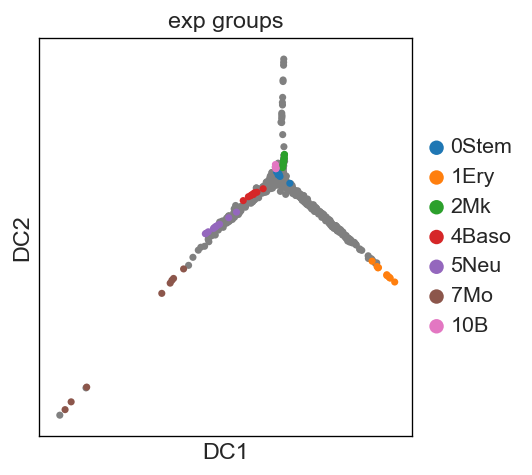

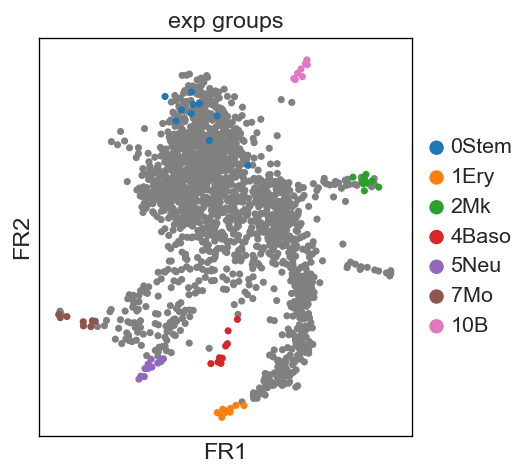

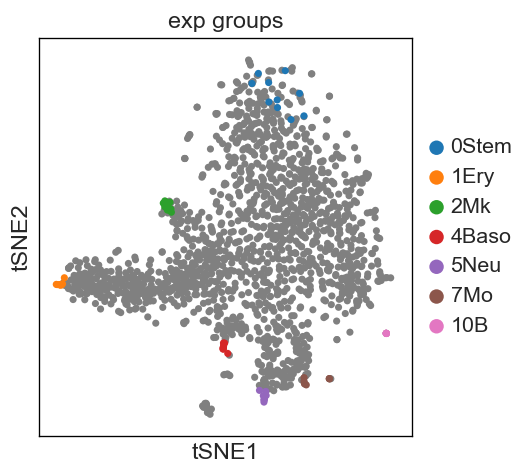

writing ./write/nestorowa16.h5


In [21]:
adata = nestorowa16()
sc.tl.diffmap(adata, n_neighbors=4)
sc.tl.draw_graph(adata, n_neighbors=4)
sc.tl.tsne(adata)

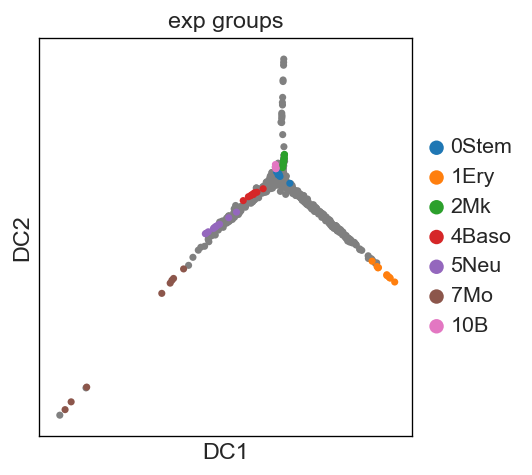

saving figure to file ./figures/draw_graph_fr.png


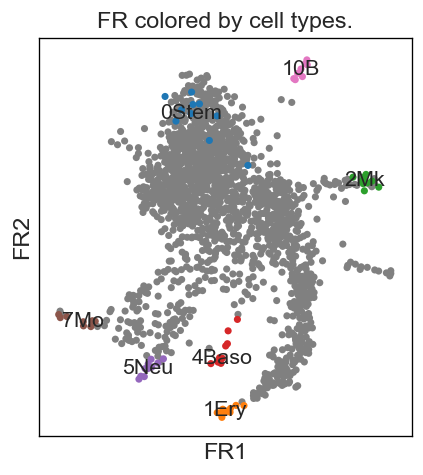

saving figure to file ./figures/tsne.png


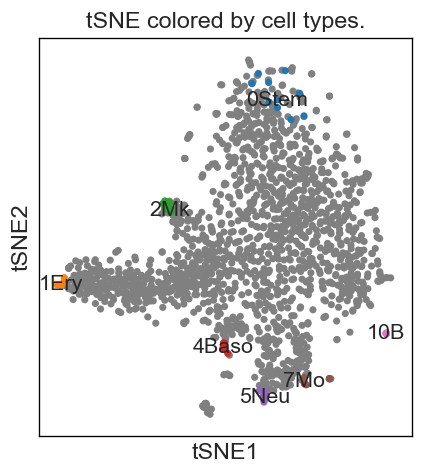

writing ./write/nestorowa16.h5


In [16]:
ax = sc.pl.diffmap(adata, color='exp_groups')
ax = sc.pl.draw_graph(adata, color='exp_groups', title='FR colored by cell types.', legend_loc='on data', save=True)
ax = sc.pl.tsne(adata, color='exp_groups', title='tSNE colored by cell types.', legend_loc='on data', save=True)
sc.write('nestorowa16', adata)

Export for comparison with Monocle 2.

In [22]:
adata_raw.add['exp_groups_colors'] = adata.add['exp_groups_colors']
adata_raw.add['exp_groups_order'] = adata.add['exp_groups_order']
sc.write('nestorowa16_raw', adata_raw, ext='csv')

writing csv files to ./write/nestorowa16_raw/


## Tree inference using graph abstraction

We use the same number of neighbors as for visualizing the data above and as in [*paul15*](../paul15).

In [23]:
adata = sc.read('nestorowa16')
sc.tl.aga(adata, n_neighbors=4, resolution=1.3, tree_detection='iterative_matching')
sc.write('nestorowa16', adata)

reading ./write/nestorowa16.h5
writing ./write/nestorowa16.h5


reading ./write/nestorowa16.h5


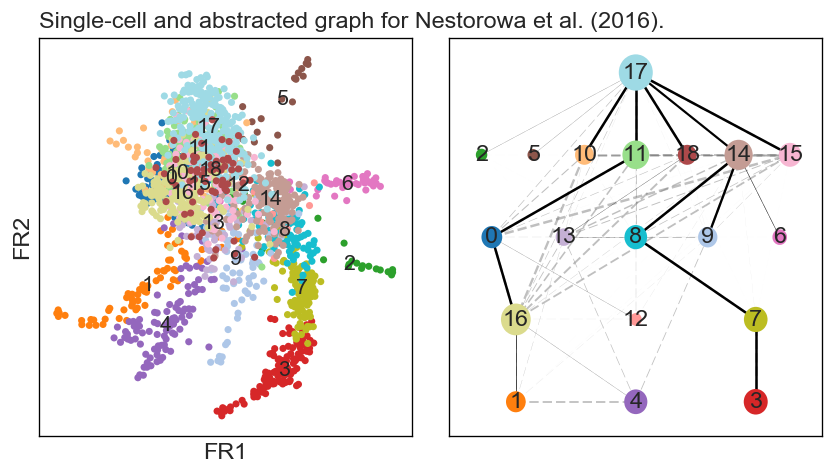

In [2]:
adata = sc.read('nestorowa16')
axs = sc.pl.aga(adata, title='', title_graph='', basis='draw_graph_fr',
                root=17, color='aga_groups', groups_graph='aga_groups', layout='eq_tree', show=False)
axs[0].set_title('Single-cell and abstracted graph for Nestorowa et al. (2016).', loc='left')
pl.savefig('./figures/aga.png', dpi=300)
pl.show()

reading ./write/nestorowa16.h5
saving figure to file ./figures/aga_graph.png


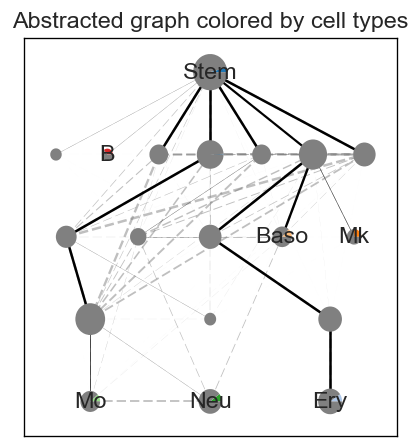

saving figure to file ./figures/aga_graph_fr.png


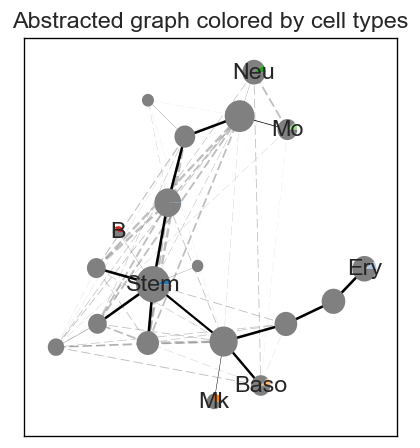

In [2]:
import re
adata = sc.read('nestorowa16')
asso_names, asso_matrix = sc.utils.compute_association_matrix_of_groups(
    adata, prediction='aga_groups', reference='exp_groups', normalization='prediction')
asso_names = [re.sub('\d+', '', n) for n in asso_names]  # remove the numbers
asso_colors = sc.utils.get_associated_colors_of_groups(sc.pl.palettes.vega_20, asso_matrix)
axs = sc.pl.aga_graph(adata,
                      title='Abstracted graph colored by cell types',
                      root=17, color=asso_colors, groups=asso_names, layout='eq_tree', save=True)
axs = sc.pl.aga_graph(adata,
                      title='Abstracted graph colored by cell types',
                      root=17, color=asso_colors, groups=asso_names, layout='fr', save='_fr')

reading ./write/nestorowa16.h5
exporting to ./write/aga_graph...


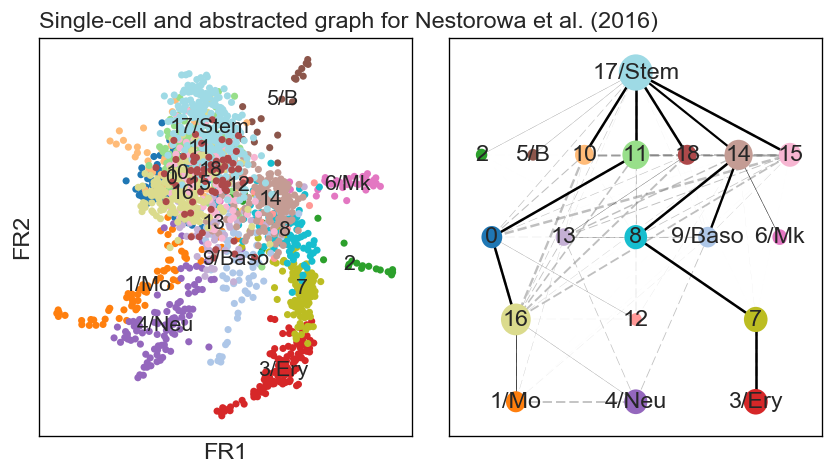

In [2]:
import re
adata = sc.read('nestorowa16')
asso_names, asso_matrix = sc.utils.compute_association_matrix_of_groups(
    adata, prediction='aga_groups', reference='exp_groups', normalization='prediction', max_n_names=1)
adata.add['aga_groups_order'] = [('{}'.format(name)
                                  + ('/{}'.format(re.sub('\d+', '', asso_names[iname])) if len(asso_names[iname])>0 else '')) # replace integers
                                 for iname, name in enumerate(adata.add['aga_groups_order'])]
axs = sc.pl.aga(adata, title='',
                basis='draw_graph_fr',
                root=17, color='aga_groups', groups_graph='aga_groups', layout='eq_tree', show=False, export_to_dot=True)
axs[0].set_title('Single-cell and abstracted graph for Nestorowa et al. (2016)', loc='left')
pl.savefig('./figures/aga.png', dpi=300)
pl.savefig('./figures/aga.svg', dpi=300)
pl.show()

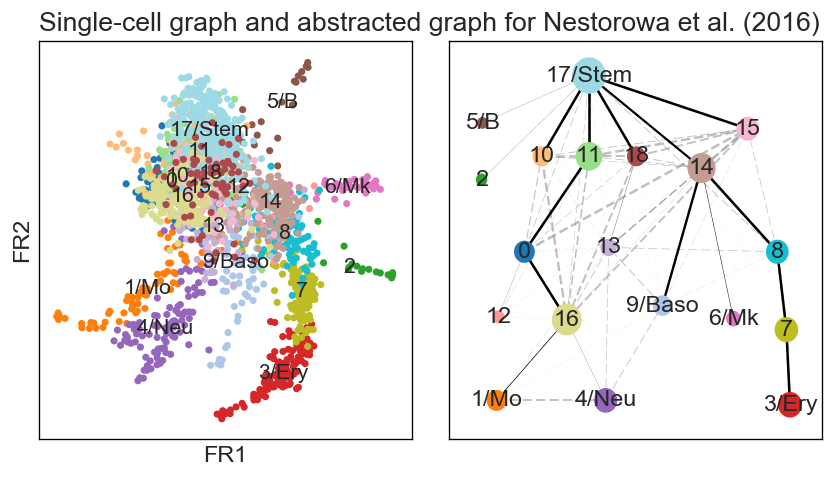

In [8]:
df = pd.read_csv('./write/aga_graph_gephi.gdf', header=-1)
pos = df[[4, 5]].values
axs = sc.pl.aga(adata, title='',
                basis='draw_graph_fr',
                root=0, color='aga_groups', groups_graph='aga_groups', show=False,
                pos=pos)
axs[0].set_title('Single-cell graph and abstracted graph for Nestorowa et al. (2016)', loc='left', fontsize=16)
pl.savefig('./figures/aga_gephi.png', dpi=300)
pl.show()

### Reconstruct dynamics for differentially expressed genes of leaf nodes

Some marker genes.

| cell type | marker |
| --- | --- |
| Erythroid | Gata1, Gypa, Hba-a2, Hba-a1 |
|Megakaryocyte | Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf |
|'3' population | Ltf, Retnlg |
|Basophils | Prss34, Ms4a2, Fcer1a, Siglecf |
|Monocyte | Irf8, Csf1r, Ctsg, Mpo |
|Neutrophils | Elane, Ctsg, Mpo, Gfi1 | 
|Lymphoid | Dntt, Il7r, Rag2 |
|B cells | Cd19, Vpreb2, Cd79a |

In [14]:
adata = sc.read('nestorowa16')
adata_all_genes = nestorowa16_raw()
sc.pp.recipe_zheng17(adata_all_genes, n_top_genes=4000)
adata_all_genes.smp['aga_groups'] = adata.smp['aga_groups']
adata_all_genes.add['aga_groups_order'] = adata.add['aga_groups_order']
adata_all_genes.smp['aga_pseudotime'] = adata.smp['aga_pseudotime']

reading ./write/nestorowa16.h5
reading ./write/data/nestorowa16/data/norm_counts_nestorowa_data.h5


In [15]:
gene_names = ['Gata2', 'Gata1', 'Hba-a2', 'Gfi1', 'Elane', 'Irf8', 'Csf1r']

reading ./write/nestorowa16.h5


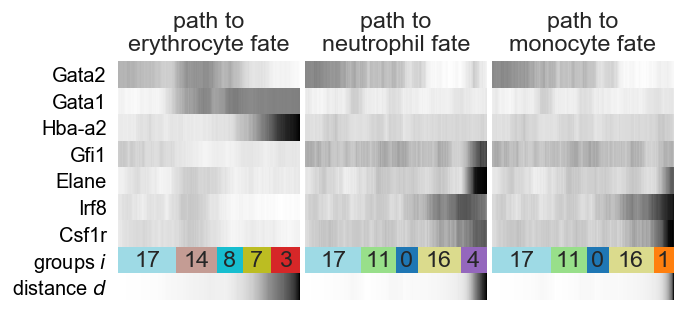

In [19]:
adata = sc.read('nestorowa16')
paths = [('erythrocytes', [17, 14, 8, 7, 3]),
         ('neutrophils', [17, 11, 0, 16, 4]),
         ('monocytes', [17, 11, 0, 16, 1])]
rcParams['figure.figsize'] = (6, 2.5)
rcParams['figure.subplot.top'] = 0.82
rcParams['figure.subplot.bottom'] = 0.2
rcParams['figure.subplot.right'] = 0.92
_, axs = pl.subplots(ncols=3, gridspec_kw={'wspace': 0.03})
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.aga_path(adata_all_genes, ax=axs[ipath],
                             left_margin=0.15,
                             nodes=path,
                             ytick_fontsize=12,
                             keys=gene_names,
                             n_avg=50,
                             show_yticks=True if ipath==0 else False,
                             show_colorbar=False,
                             title='path to\n{} fate'.format(descr[:-1]),
                             return_data=True, show=False)
    data.to_csv('./write/aga_path_{}.csv'.format(descr))
pl.savefig('./figures/aga_path.png', dpi=300)
pl.show()
sc.pl.reset_rcParams()